In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/malayakew-plant-leaf-dataset/MK/readMe.txt
/kaggle/input/malayakew-plant-leaf-dataset/MK/name_of_spesies.txt
/kaggle/input/malayakew-plant-leaf-dataset/MK/D2/test_patch/Class26/Class26(8)R225_00163.jpg
/kaggle/input/malayakew-plant-leaf-dataset/MK/D2/test_patch/Class26/Class26(7)R45_00145.jpg
/kaggle/input/malayakew-plant-leaf-dataset/MK/D2/test_patch/Class26/Class26(6)R90_00108.jpg
/kaggle/input/malayakew-plant-leaf-dataset/MK/D2/test_patch/Class26/Class26(5)R225_00097.jpg
/kaggle/input/malayakew-plant-leaf-dataset/MK/D2/test_patch/Class26/Class26(8)R315_00162.jpg
/kaggle/input/malayakew-plant-leaf-dataset/MK/D2/test_patch/Class26/Class26(4)R180_00074.jpg
/kaggle/input/malayakew-plant-leaf-dataset/MK/D2/test_patch/Class26/Class26(7)R180_00141.jpg
/kaggle/input/malayakew-plant-leaf-dataset/MK/D2/test_patch/Class26/Class26(3)R225_00050.jpg
/kaggle/input/malayakew-plant-leaf-dataset/MK/D2/test_patch/Class26/Class26(7)R0_00145.jpg
/kaggle/input/malayakew-plant-leaf-dataset/M

# Image Loading Utility with Class Labels

In [23]:
import cv2
import numpy as np
import os

def load_images_opencv(root_folder, class_folders, target_size=(128, 128)):
    data = []
    labels = []

    for class_label, class_folder in enumerate(class_folders):
        class_path = os.path.join(root_folder, class_folder)

        if not os.path.isdir(class_path):
            continue

        for file_name in os.listdir(class_path):
            if file_name.endswith(('.jpg', '.png')):
                image_path = os.path.join(class_path, file_name)
                image = cv2.imread(image_path)
                if image is not None:
                    resized_image = cv2.resize(image, target_size)
                    data.append(resized_image)
                    labels.append(class_label)

    return np.array(data), np.array(labels)



In [24]:
train_data = '/kaggle/input/malayakew-plant-leaf-dataset/MK/D1/train'
test_data = '/kaggle/input/malayakew-plant-leaf-dataset/MK/D1/test'

In [25]:
selected_folders10_17 = ['Class (10)', 'Class (17)']  

**Data (10&17)**

In [26]:
X_train, y_train = load_images(train_data, selected_folders10_17)
X_test, y_test = load_images(test_data, selected_folders10_17)

In [27]:
print("X_train10_17", X_train.shape)
print("y_train10_17", y_train.shape)
print("X_test10_17", X_test.shape)
print("y_test10_17", y_test.shape)

X_train10_17 (104, 128, 128, 3)
y_train10_17 (104,)
X_test10_17 (24, 128, 128, 3)
y_test10_17 (24,)


In [28]:
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

# **Normalize Data**

In [29]:
X_train=X_train.astype('float32')/255.0
X_test=X_test.astype('float32')/255.0

# **Data augmentation**

In [30]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator as DataGenerator

data_augmentor = DataGenerator(
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='constant'
)

def apply_augmentation(data):
    augmented_images = []
    for image_data in data:
        expanded_image = np.expand_dims(image_data, axis=0)
        for _ in range(5): #5 times
            seed = np.random.randint(0, 1000)
            for batch_data in data_augmentor.flow(expanded_image, batch_size=1, seed=seed):
                augmented_images.append(np.squeeze(batch_data))
                break
    return np.array(augmented_images)


In [31]:
X_train_augmented = apply_augmentation(X_train)
y_train_augmented = np.repeat(y_train,5, axis=0)
X_test_augmented = apply_augmentation(X_test)
y_test_augmented = np.repeat(y_test,5, axis=0)

In [32]:
print("X_train10_17_augmented", X_train_augmented.shape)
print("y_train10_17_augmented", y_train_augmented.shape)
print("X_test10_17_augmented", X_test_augmented.shape)
print("y_test10_17_augmented", y_test_augmented.shape)

X_train10_17_augmented (520, 128, 128, 3)
y_train10_17_augmented (520,)
X_test10_17_augmented (120, 128, 128, 3)
y_test10_17_augmented (120,)


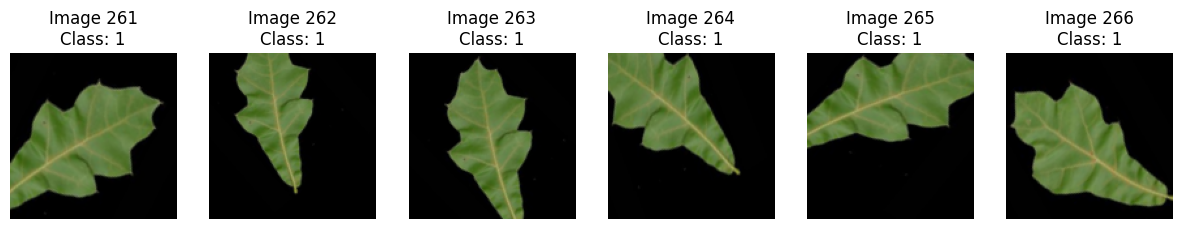

In [35]:
import matplotlib.pyplot as plt

def display_images(images, labels, start_index, num_images_to_display):
    fig, axes = plt.subplots(1, num_images_to_display, figsize=(15, 5))

    for i in range(num_images_to_display):
        axes[i].imshow(images[start_index + i])
        axes[i].axis('off')
        class_label = labels[start_index + i]
        axes[i].set_title(f"Image {start_index + i + 1}\nClass: {class_label}")

    plt.show()
display_images(X_train_augmented,y_train_augmented,260,6)

In [36]:
from sklearn.utils import shuffle as data_shuffle

def combine_img(data1, labels1, data2, labels2):
    combined_data = np.concatenate((data1, data2))
    combined_labels = np.concatenate((labels1, labels2))

    # Shuffle the combined data
    combined_data, combined_labels = data_shuffle(combined_data, combined_labels, random_state=40)
    return combined_data, combined_labels

In [37]:
X_train_combined, y_train_combined = combine_img(X_train, y_train, X_train_augmented, y_train_augmented)
X_test_combined, y_test_combined = combine_img(X_test, y_test, X_test_augmented, y_test_augmented)

In [38]:
print("X_train_combined", X_train_combined.shape)
print("y_train_combined", y_train_combined.shape)
print("X_test_combined", X_test_combined.shape)
print("y_test_combined", y_test_combined.shape)

X_train_combined (624, 128, 128, 3)
y_train_combined (624,)
X_test_combined (144, 128, 128, 3)
y_test_combined (144,)


In [43]:
metrics = [
                             'accuracy',
                             tf.keras.metrics.AUC(),
                             tf.keras.metrics.Recall(),
                             tf.keras.metrics.Precision(),
                             tf.keras.metrics.FalseNegatives(),
                             tf.keras.metrics.FalsePositives(),
                             tf.keras.metrics.TrueNegatives(),
                             tf.keras.metrics.TruePositives(),
                             tf.keras.metrics.F1Score()]

In [44]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras import regularizers

def InceptionV3_model(hp):
    base = InceptionV3(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

    for layer in base.layers:
        layer.trainable = False
    custom_model = keras.Sequential()
    custom_model.add(base)
    custom_model.add(keras.layers.GlobalAveragePooling2D())
    for i in range(1, 4):
        units_key = f'units{i}'
        dropout_key = f'dropout{i}'
        
        Hyper = hp.Int(units_key, min_value=32, max_value=512, step=32)
        hp_dropout = hp.Float(dropout_key, min_value=0.2, max_value=0.6, step=0.1)
        
        custom_model.add(layers.Dense(units=Hyper, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
        custom_model.add(layers.Dropout(hp_dropout))

    
    custom_model.add(layers.Dense(1, activation='sigmoid'))


    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    custom_model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                         loss='binary_crossentropy',
                         metrics=metrics)

    return custom_model


# **DenseNet**

In [64]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

def DenseNet_model(hp):
    # Load modified DenseNet model from Keras Applications
    base = keras.applications.DenseNet201(input_shape=(128, 128, 3), include_top=False, weights='imagenet')

    # Freeze the layers of the pre-trained DenseNet
    for layer in base.layers:
        layer.trainable = False

    custom_model = keras.Sequential()

    # Add the modified DenseNet model
    custom_model.add(base)

    # Flatten the output of DenseNet
    custom_model.add(keras.layers.GlobalAveragePooling2D())

    # Dense layers with hyperparameters
    for i in range(1, 4):
        units_key = f'units{i}'
        dropout_key = f'dropout{i}'
        
        hp_units = hp.Int(units_key, min_value=32, max_value=512, step=32)
        hp_dropout = hp.Float(dropout_key, min_value=0.2, max_value=0.6, step=0.1)
        
        custom_model.add(layers.Dense(units=hp_units, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)))
        custom_model.add(layers.Dropout(hp_dropout))

    # Output layer
    custom_model.add(layers.Dense(1, activation='sigmoid'))

    # Hyperparameter for learning rate
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    # Compile the model
    custom_model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                         loss='binary_crossentropy',
                         metrics=metrics)

    return custom_model


In [65]:

import kerastuner as kt
from tensorflow import keras
from tensorflow.keras.applications import DenseNet201

# Define the objective
objective = kt.Objective(
    name="val_accuracy",
    direction="max"
)

# Define the hyperband tuner with DenseNet model
tuner = kt.Hyperband(
    DenseNet_model,
    objective=objective,
    max_epochs=10,
    factor=3,
    directory='my_dir',
    project_name='Hyperband_DenseNet'
)


74836368/74836368 [==============================] - 3s 0us/step


In [45]:

import kerastuner as kt
from tensorflow import keras
from tensorflow.keras.applications import DenseNet201

# Define the objective
objective = kt.Objective(
    name="val_accuracy",
    direction="max"
)

# Define the hyperband tuner with DenseNet model
tuner = kt.Hyperband(
    InceptionV3_model,
    objective=objective,
    max_epochs=10,
    factor=3,
    directory='my_dirInception2',
    project_name='Hyperband_Inception'
)


In [46]:
import tensorflow as tf
from tensorflow.keras import callbacks
from IPython.display import clear_output

class ClearTrainingOutput(callbacks.Callback):
    def on_train_end(self, *args, **kwargs):
        clear_output(wait=True)

In [48]:
tuner.search(X_train_combined,y_train_combined.astype('float32'),epochs=10,validation_split=0.2,callbacks=[ClearTrainingOutput()])
hyperparameters=tuner.get_best_hyperparameters(num_trials=1)[0]
InceptionV3_model =tuner.hypermodel.build(hyperparameters)
tuner.search_space_summary()

Trial 28 Complete [00h 00m 21s]
val_accuracy: 0.9919999837875366

Best val_accuracy So Far: 1.0
Total elapsed time: 00h 09m 51s
Search space summary
Default search space size: 7
units1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
dropout1 (Float)
{'default': 0.2, 'conditions': [], 'min_value': 0.2, 'max_value': 0.6, 'step': 0.1, 'sampling': 'linear'}
units2 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
dropout2 (Float)
{'default': 0.2, 'conditions': [], 'min_value': 0.2, 'max_value': 0.6, 'step': 0.1, 'sampling': 'linear'}
units3 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
dropout3 (Float)
{'default': 0.2, 'conditions': [], 'min_value': 0.2, 'max_value': 0.6, 'step': 0.1, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordere

In [49]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=3)  

history=InceptionV3_model.fit(X_train_combined,y_train_combined.astype('float32'),epochs=10,validation_split=0.2,callbacks=[early_stopping,ClearTrainingOutput()])

Epoch 1/10
16/16 [==============================] - 10s 243ms/step - loss: 11.6105 - accuracy: 0.9138 - auc_3: 0.9872 - recall_3: 0.9167 - precision_3: 0.9408 - false_negatives_3: 26.0000 - false_positives_3: 18.0000 - true_negatives_3: 294.0000 - true_positives_3: 286.0000 - f1_score: 0.6717 - val_loss: 9.4662 - val_accuracy: 0.9920 - val_auc_3: 0.9997 - val_recall_3: 1.0000 - val_precision_3: 0.9848 - val_false_negatives_3: 0.0000e+00 - val_false_positives_3: 1.0000 - val_true_negatives_3: 59.0000 - val_true_positives_3: 65.0000 - val_f1_score: 0.7263
Epoch 2/10
16/16 [==============================] - 1s 43ms/step - loss: 7.9510 - accuracy: 0.9980 - auc_3: 1.0000 - recall_3: 0.9960 - precision_3: 1.0000 - false_negatives_3: 1.0000 - false_positives_3: 0.0000e+00 - true_negatives_3: 252.0000 - true_positives_3: 246.0000 - f1_score: 0.7554 - val_loss: 6.4161 - val_accuracy: 0.9920 - val_auc_3: 0.9915 - val_recall_3: 1.0000 - val_precision_3: 0.9848 - val_false_negatives_3: 0.0000e+00 

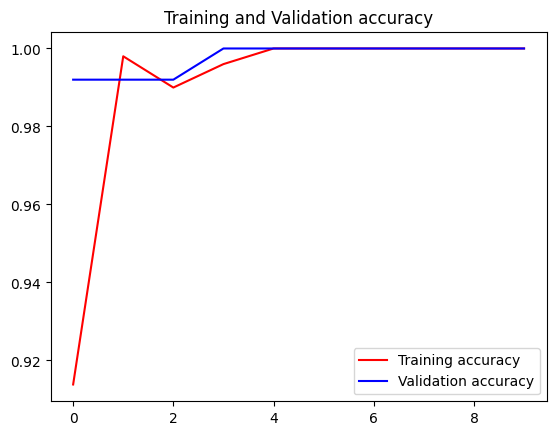

<Figure size 640x480 with 0 Axes>

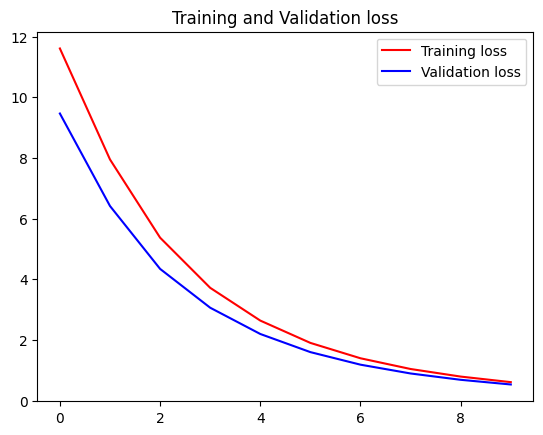

<Figure size 640x480 with 0 Axes>

In [50]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc= history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs,acc,'r',label="Training accuracy")
plt.plot(epochs,val_acc,'b',label="Validation accuracy")
plt.title('Training and Validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

plt.plot(epochs,loss,'r',label="Training loss")
plt.plot(epochs,val_loss,'b',label="Validation loss")
plt.title('Training and Validation loss')
plt.legend(loc=0)
plt.figure()
plt.show()

In [51]:
InceptionV3_model.evaluate(new_X_test10_17,new_y_test10_17.astype('float32'))

5/5 [==============================] - 0s 42ms/step - loss: 0.5285 - accuracy: 1.0000 - auc_3: 1.0000 - recall_3: 1.0000 - precision_3: 1.0000 - false_negatives_3: 0.0000e+00 - false_positives_3: 0.0000e+00 - true_negatives_3: 72.0000 - true_positives_3: 72.0000 - f1_score: 0.6667


[0.5284515023231506,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 72.0,
 72.0,
 array([0.6666667], dtype=float32)]